# Linear Optimal Transport 

Let $[p_i]_{i=1}^M$ be probability distributions, and let $X_i=[x^i_k\in \mathbb{R}^d \sim p_i]_{k=1}^{N_i}\in \mathbb{R}^{N_i\times d}$ be the set of $N_i$ samples from distribution $p_i$. Let us define $p_0$ to be a template distribution, with $X_0=[x^0_k\in \mathbb{R}^d \sim p_0]_{k=1}^{N}$, where $N=\lfloor \frac{1}{M}\sum_{i=1}^M N_i \rfloor$. 

## Optimal Transport - Kantorovich Formulation

The transport plan between $p_i$ and $p_0$ is calculated from solving the following linear program:

$$ \pi^* = argmin_{\pi} \sum_{k=1}^{N}\sum_{l=1}^{N_i} \pi_{kl}\| x^0_k - x^i_l \|^2$$ 

$$ s.t. \sum_{k} \pi_{kl}=\frac{1}{N_i}~,~\sum_{l} \pi_{kl}=\frac{1}{N} $$

where $\pi^*\in \mathbb{R}^{N\times N_i}$. The transport map is obtained via: $F_i= N(\pi^* X_i)\in \mathbb{R}^{M\times d}$ and we define the transport displacement to be $V_i=F_i-X_0$. 

Given $X_0$, $V_i$ "uniquely" identifies $X_i$. The mapping from $X_i$ to $V_i$ is what we denote as a Transport-Based Transform, and below we demonstrate its nonlinear characteristics. 

## Walkthrough

In [1]:
import numpy as np
from sklearn.datasets import make_swiss_roll, make_moons, make_circles
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import ot
import idx2numpy

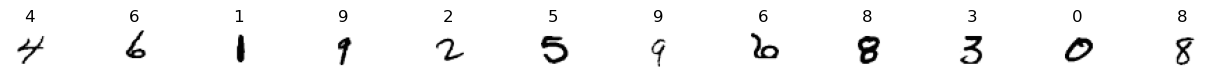

In [2]:
file = 'data/train-images.idx3-ubyte'
mnist_train_images = idx2numpy.convert_from_file(file)

file = 'data/train-labels.idx1-ubyte'
mnist_train_labels = idx2numpy.convert_from_file(file)


# visualize some digits
plt.figure(figsize=(16,0.5))
for i in range(12):
    plt.subplot(1, 12, i+1)
    idx = np.random.randint(mnist_train_images.shape[0])
    plt.imshow(mnist_train_images[idx], cmap='Greys')
    plt.title(mnist_train_labels[idx])
    plt.axis('off')

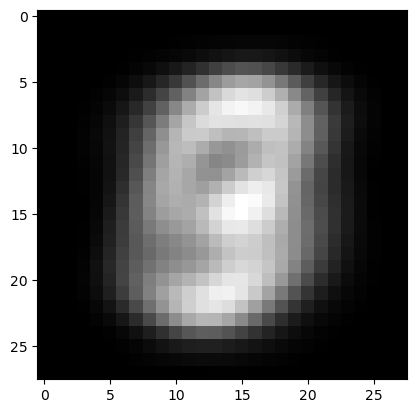

In [4]:
average_image = np.mean(mnist_train_images, axis=0)
ref = average_image/average_image.sum()
# Visualize the average image
plt.imshow(ref, cmap='gray')

In [5]:
# image size
N = 28

# create point clouds and associated masses
point_clouds, masses = {}, {}
for i in range(len(mnist_train_images)):
    # extract support of point cloud
    idxes = np.where(mnist_train_images[i]>0)
    cloud = np.zeros((len(idxes[0]), 2))
    cloud[:, 0] = idxes[1]/N
    cloud[:, 1] = 1 - idxes[0]/N
    point_clouds[i] = cloud
    # extract masses of point cloud
    nu = mnist_train_images[i][np.where(mnist_train_images[i]>0)] + 1
    masses[i] = np.zeros_like(ref)
    masses[i][np.where(mnist_train_images[i]>0)] = nu / np.sum(nu)

C:\Users\Sirius\AppData\Local\Temp\ipykernel_18748\2810618656.py:16: RuntimeWarning: invalid value encountered in divide
  masses[i][np.where(mnist_train_images[i]>0)] = nu / np.sum(nu)


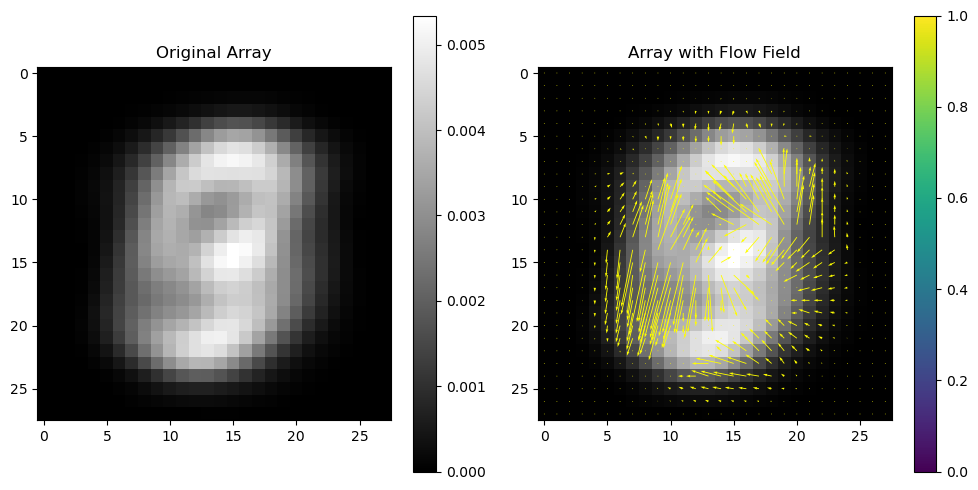

<Figure size 640x480 with 0 Axes>

In [6]:
import ot
import numpy as np

# Example 28x28 arrays (replace these with your actual arrays)
array1 = ref
array2 = masses[0]

# Normalize the arrays
array1 /= array1.sum()
array2 /= array2.sum()

# Create a 4D cost matrix
xx1, yy1 = np.meshgrid(range(28), range(28))
xx2, yy2 = np.meshgrid(range(28), range(28))
X1 = np.stack([xx1.ravel(), yy1.ravel()], axis=-1)
X2 = np.stack([xx2.ravel(), yy2.ravel()], axis=-1)
M = ot.dist(X1, X2, metric='euclidean')
M = M.reshape(28, 28, 28, 28)

# Compute optimal transport plan
transport_plan = ot.emd(array1.ravel(), array2.ravel(), M.reshape(28*28, 28*28))

# transport_plan now contains the 2D optimal transport plan
transport_plan_reshaped = transport_plan.reshape(28, 28, 28, 28)

# Initialize a flow field
flow_field = np.zeros((28, 28, 2))

# Calculate the flow field
for i in range(28):
    for j in range(28):
        flow = np.zeros(2)
        for k in range(28):
            for l in range(28):
                flow += transport_plan_reshaped[i, j, k, l] * np.array([k-i, l-j])
        flow_field[i, j, :] = flow

# Visualizing the flow field
plt.figure(figsize=(10, 5))

# Original array
plt.subplot(1, 2, 1)
plt.title("Original Array")
plt.imshow(array1, cmap='gray')
plt.colorbar()

# Array with flow field
plt.subplot(1, 2, 2)
plt.title("Array with Flow Field")
plt.imshow(array1, cmap='gray')
plt.quiver(np.arange(28), np.arange(28), flow_field[:, :, 1], -flow_field[:, :, 0], color='yellow')
plt.colorbar()

plt.tight_layout()
plt.show()
plt.savefig("flow_field.jpg")

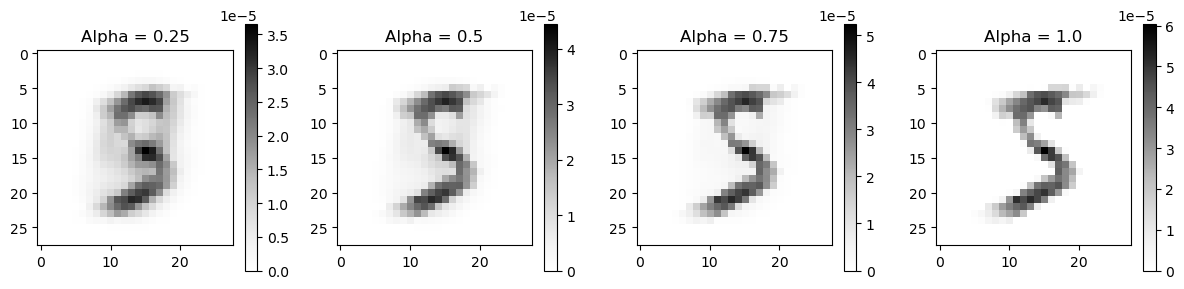

<Figure size 640x480 with 0 Axes>

In [7]:
def interpolate_distributions(array1, array2, alpha, transport_plan):
    interpolated_array = np.zeros_like(array1)
    for i in range(28):
        for j in range(28):
            for k in range(28):
                for l in range(28):
                    mass = transport_plan[i, j, k, l]
                    interpolated_array[k, l] += alpha * mass * array2[i, j]
                    interpolated_array[i, j] += (1 - alpha) * mass * array1[i, j]
    return interpolated_array

# Alphas for different stages of transport
alphas = [0.25, 0.5, 0.75, 1.0]

# Visualize the transport process
plt.figure(figsize=(12, 3))
for idx, alpha in enumerate(alphas):
    interpolated_array = interpolate_distributions(array1, array2, alpha, transport_plan_reshaped)
    plt.subplot(1, len(alphas), idx + 1)
    plt.imshow(interpolated_array, cmap='Grays')
    plt.title(f"Alpha = {alpha}")
    plt.colorbar()

plt.tight_layout()
plt.show()
plt.savefig("OT_process.png")

In [8]:
transport_plan.shape

(784, 784)

In [9]:
def calculate_linear_embedding(transport_plan, sigma, nu_n):
    # Get the coordinates of each pixel in the images
    sigma_coords = np.indices(sigma.shape).reshape(2, -1).T  # Coordinates in sigma (28x28)
    nu_n_coords = np.indices(nu_n.shape).reshape(2, -1).T    # Coordinates in nu_n (28x28)
    N_sigma = sigma.size  # 784
    x_n = np.zeros((N_sigma, 2))

    # Normalize the reference image to get masses (probabilities)
    sigma_masses = sigma.ravel() / sigma.sum()

    # Calculate the linear embedding
    for k in range(N_sigma):
        for i in range(N_sigma):
            mass_distribution = transport_plan[k, i]
            x_n[k] += mass_distribution * nu_n_coords[i] * sigma_masses[k]

    return x_n

# Example usage
#transport_plan = ...  # OT plan matrix of size 784x784 (flattened from 28x28x28x28)

x_n = calculate_linear_embedding(transport_plan, array1, array2)

# x_n contains the isometric linear embedding of array2 based on the transport plan


In [10]:
x_n.shape

(784, 2)

In [12]:
import ot
import numpy as np

# Assuming array1 is your reference image and masses is a list of images

def compute_transport_plan(array1, array2):
    array1 /= array1.sum()
    array2 /= array2.sum()

    xx1, yy1 = np.meshgrid(range(28), range(28))
    xx2, yy2 = np.meshgrid(range(28), range(28))
    X1 = np.stack([xx1.ravel(), yy1.ravel()], axis=-1)
    X2 = np.stack([xx2.ravel(), yy2.ravel()], axis=-1)
    M = ot.dist(X1, X2, metric='euclidean')
    M = M.reshape(28, 28, 28, 28)

    transport_plan = ot.emd(array1.ravel(), array2.ravel(), M.reshape(28*28, 28*28))
    return transport_plan

def calculate_linear_embedding(transport_plan, sigma, nu_n):
    sigma_coords = np.indices(sigma.shape).reshape(2, -1).T
    nu_n_coords = np.indices(nu_n.shape).reshape(2, -1).T
    N_sigma = sigma.size
    x_n = np.zeros((N_sigma, 2))
    sigma_masses = sigma.ravel() / sigma.sum()

    for k in range(N_sigma):
        for i in range(N_sigma):
            mass_distribution = transport_plan[k, i]
            x_n[k] += mass_distribution * nu_n_coords[i] * sigma_masses[k]

    return x_n

# Normalize the reference image
#array1_normalized = array1 / array1.sum()

# Compute the linear embeddings for each image in masses
#linear_embeddings = {}
#for key, array2 in masses.items():
#    transport_plan = compute_transport_plan(ref, array2)
#    x_n = calculate_linear_embedding(transport_plan, ref, array2)
#    linear_embeddings[key] = x_n
# linear_embeddings now contains the linear embeddings for each image in masses



subset_keys = list(masses.keys())[:len(masses) // 10000]

# Compute the linear embeddings for the selected subset of images
linear_embeddings_subset = []
for key in subset_keys:
    array2 = masses[key]
    transport_plan = compute_transport_plan(ref, array2)
    x_n = calculate_linear_embedding(transport_plan, ref, array2)
    linear_embeddings_subset.append(x_n)


In [13]:
linear_embeddings_subset

[array([[0., 0.],
        [0., 0.],
        [0., 0.],
        ...,
        [0., 0.],
        [0., 0.],
        [0., 0.]]),
 array([[0., 0.],
        [0., 0.],
        [0., 0.],
        ...,
        [0., 0.],
        [0., 0.],
        [0., 0.]]),
 array([[0., 0.],
        [0., 0.],
        [0., 0.],
        ...,
        [0., 0.],
        [0., 0.],
        [0., 0.]]),
 array([[0., 0.],
        [0., 0.],
        [0., 0.],
        ...,
        [0., 0.],
        [0., 0.],
        [0., 0.]]),
 array([[0., 0.],
        [0., 0.],
        [0., 0.],
        ...,
        [0., 0.],
        [0., 0.],
        [0., 0.]]),
 array([[0., 0.],
        [0., 0.],
        [0., 0.],
        ...,
        [0., 0.],
        [0., 0.],
        [0., 0.]])]

In [14]:
linear_embeddings_subset[0].shape

(784, 2)

Let us first generate a dataset of $p_i$s (or better to say $X_i$s). We generate a list of $X_i$s and name the list $X$.

Here we calculate the transport plan and the approximated transport map by solving the Kantorovich problem. Then we visualize the geodesic between $p_i$ and $p_0$ via: 

$$ X_i^\alpha = X_0+\alpha V_i $$

for $\alpha \in [0,1]$.

Now we calculate $V_i$s for the entire dataset, and put them in an array (because $V_i\in\mathbb{R}^{N\times d}~$).